In [1]:
from collections.abc import Callable
from types import MappingProxyType

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from input_data import lb3_time_opticaldensity_ph_glucose_protein_37

In [2]:
_TIMESTAMPS: int = len(lb3_time_opticaldensity_ph_glucose_protein_37) - 1
_TIME_VALUES: np.ndarray = lb3_time_opticaldensity_ph_glucose_protein_37['Time'].values

In [3]:
def model(
    params: np.ndarray,
    input_data: pd.DataFrame,
    timestamps: int,
    temperature: float = 1.0,
    aeration: float = 1.0,
    stirring: float = 1.0,
) -> tuple[np.ndarray, ...]:
    optical_densitys, phs, glucoses, proteins = (
        [input_data["OpticalDensity"].iloc[0]],
        [input_data["pH"].iloc[0]],
        [input_data["Glucose"].iloc[0]],
        [input_data["Protein"].iloc[0]],
    )

    for _ in range(timestamps):
        optical_density, ph, glucose, protein = optical_densitys[-1], phs[-1], glucoses[-1], proteins[-1]
        environmental_effect = temperature * aeration * stirring

        optical_density_base = (
            params[0] * optical_density
            + params[1] * ph
            + params[2] * glucose
            + params[3] * protein
        )
        optical_density_next = optical_density_base * environmental_effect
        ph_next = params[4] + params[5] * ph - params[6] * optical_density_next
        glucose_next = glucose - params[7] * optical_density_next
        protein_next = protein + params[8] * optical_density_next - params[9] * protein

        optical_densitys.append(optical_density_next)
        phs.append(ph_next)
        glucoses.append(glucose_next)
        proteins.append(protein_next)
    return np.array(optical_densitys), np.array(phs), np.array(glucoses), np.array(proteins)

In [4]:
params = np.random.rand(14) * 0.01
params

array([0.00731378, 0.00451925, 0.0048596 , 0.00545434, 0.00816692,
       0.00693593, 0.00973356, 0.00984691, 0.00407714, 0.00121298,
       0.00304984, 0.00752095, 0.00342873, 0.00715657])

In [5]:
def normalize(
    optical_density: np.ndarray,
    ph: np.ndarray,
    glucose: np.ndarray,
    protein: np.ndarray
) -> tuple[float]:
    _std = lambda x: float(np.std(x)) if float(np.std(x)) > 0 else 1.0
    return map(_std, (optical_density, ph, glucose, protein))


def make_loss(input_data: pd.DataFrame, timestamps: int = _TIMESTAMPS) -> Callable:
    optical_desnity_obs = input_data["OpticalDensity"].values
    ph_obs = input_data["pH"].values
    glucose_obs = input_data["Glucose"].values
    protein_obs = input_data["Protein"].values

    std_optical_density, std_ph, std_glucose, std_protein = normalize(
        optical_desnity_obs, ph_obs, glucose_obs, protein_obs
    )

    def loss(params: np.ndarray) -> float:
        optical_density_pred, ph_pred, glucose_pred, protein_pred = model(
            params, input_data, timestamps
        )
        rX  = (optical_density_pred  - optical_desnity_obs) / std_optical_density
        rpH = (ph_pred - ph_obs) / std_ph
        rG  = (glucose_pred  - glucose_obs) / std_glucose
        rB  = (protein_pred  - protein_obs) / std_protein
        error = float(np.sum(rX**2) + np.sum(rpH**2) + np.sum(rG**2) + np.sum(rB**2))
        return error
    return loss

In [6]:
loss_func = make_loss(lb3_time_opticaldensity_ph_glucose_protein_37)
optimal_params = minimize(
    loss_func,
    params,
    method='L-BFGS-B',
    options={'maxiter': 10_000}
)
optimal_params.x

array([-3.15393625e+00, -1.44662314e+00, -6.07341645e-02,  9.76060573e-01,
        6.46265954e+00, -7.51793218e-02,  2.06396324e+00,  3.50788578e+00,
       -1.16542683e+00, -9.28963880e-02,  3.04984284e-03,  7.52095005e-03,
        3.42872535e-03,  7.15656539e-03])

In [7]:
optical_density_model_temp37, ph_temp_37, glucoses_temp_37, proteins_temp_37 = model(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS
)
optical_density_model_temp35, ph_temp_35, glucoses_temp_35, proteins_temp_35 = model(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS
)

In [8]:
def plot_optical_density_multi_temp(
    input_data: pd.DataFrame,
    model_curves: dict[str, np.ndarray],
    title: str = 'DBN model simulation with optimized parameters'
):
    time = input_data['Time'].values
    plt.figure(figsize=(10, 6))

    for label, y in model_curves.items():
        plt.plot(time, y, label=f'OpticalDensity model ({label})', marker='o')
    
    plt.plot(
        time, input_data['OpticalDensity'].values, 'o--', label='OpticalDensity experimental'
    )
    plt.legend()
    plt.xlabel('Time (hours)')
    plt.ylabel('Optical Density')
    plt.title(title)
    plt.grid()
    plt.show()

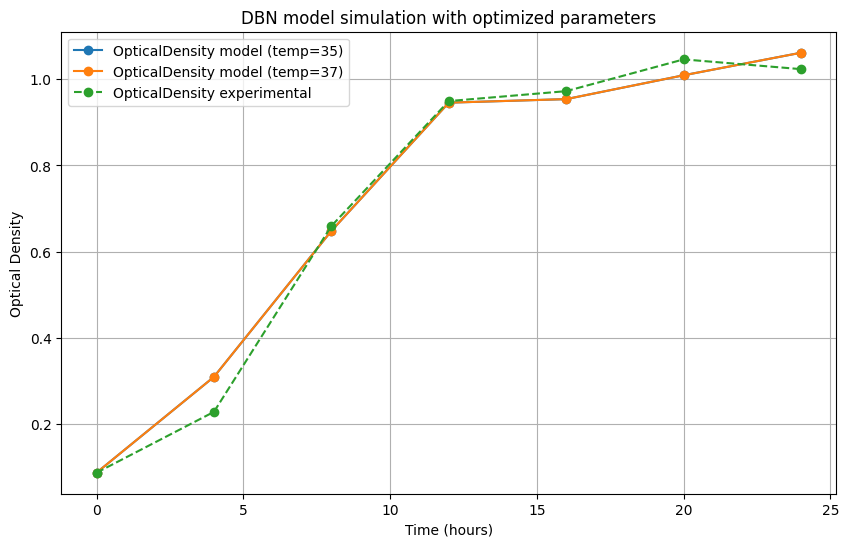

In [9]:
plot_optical_density_multi_temp(
    lb3_time_opticaldensity_ph_glucose_protein_37,
    {
        'temp=35': optical_density_model_temp35,
        'temp=37': optical_density_model_temp37,
    },
)

## Apply postprocessing

In [10]:
def apply_environmental_reduction_postprocess(
    optical_density_optimal: np.ndarray,
    temperature_reduction: float = 1.0,
    aeration_reduction: float = 1.0,
    stirring_reduction: float = 1.0,
) -> np.ndarray:
    """
    Apply environmental effects as post-processing to maintain consistent percentage reduction.
    This approach multiplies the optimal trajectory by environmental multipliers,
    ensuring that the reduction is maintained throughout the entire trajectory
    """
    total_multiplier = temperature_reduction * aeration_reduction * stirring_reduction
    return optical_density_optimal * total_multiplier

In [ ]:
# Environmental effects optimal params

_TEMPERATURES: MappingProxyType = MappingProxyType({
    '35C': 0.976458,
    '37C': 1.0,
    '40C': 0.950491,
    '45C': 0.814320
})
_AERATION: MappingProxyType = MappingProxyType({
    "154mm": 0.789030,
    "517mm": 0.793249, 
    "2289mm": 0.943460,
    "3017mm": 1.000000,
})
_STIRRING: MappingProxyType = MappingProxyType({
    '0rpm': 0.7894736842105263,
    '50rpm': 1.0,
    '100rpm': 0.8708133971291867,
    '150rpm': 0.767464114832536
})

In [12]:
optical_density_model_temp35 = apply_environmental_reduction_postprocess(
    optical_density_model_temp37,
    temperature_reduction=_TEMPERATURES['35C'],
    aeration_reduction=_AERATION['154mm'],
    stirring_reduction=_STIRRING['0rpm'],
)

optical_density_model_temp40 = apply_environmental_reduction_postprocess(
    optical_density_model_temp37,
    temperature_reduction=_TEMPERATURES['40C'],
)

optical_density_model_temp45 = apply_environmental_reduction_postprocess(
    optical_density_model_temp37,
    temperature_reduction=_TEMPERATURES['45C']
)

# Verify the reduction is maintained
print("Percentage Difference from Optimal at Each Timestamp:\n")
for i, time in enumerate(_TIME_VALUES):
    temp_35 = (
        (optical_density_model_temp35[i] - optical_density_model_temp37[i])
        / optical_density_model_temp37[i] * 100
    )
    temp_40 = (
        (optical_density_model_temp40[i] - optical_density_model_temp37[i]) 
        / optical_density_model_temp37[i] * 100
    )
    temp_45 = (
        (optical_density_model_temp45[i] - optical_density_model_temp37[i]) 
        / optical_density_model_temp37[i] * 100
    )
    print(
        f"time={time:4.1f}h: 35C reduction = {temp_35:6.2f}, 40C reduction = {temp_40:6.2f}, 45C reduction = {temp_45:6.2f}"
    )

Percentage Difference from Optimal at Each Timestamp:

time= 0.0h: 35C reduction = -39.17, 40C reduction =  -4.95, 45C reduction = -18.57
time= 4.0h: 35C reduction = -39.17, 40C reduction =  -4.95, 45C reduction = -18.57
time= 8.0h: 35C reduction = -39.17, 40C reduction =  -4.95, 45C reduction = -18.57
time=12.0h: 35C reduction = -39.17, 40C reduction =  -4.95, 45C reduction = -18.57
time=16.0h: 35C reduction = -39.17, 40C reduction =  -4.95, 45C reduction = -18.57
time=20.0h: 35C reduction = -39.17, 40C reduction =  -4.95, 45C reduction = -18.57
time=24.0h: 35C reduction = -39.17, 40C reduction =  -4.95, 45C reduction = -18.57


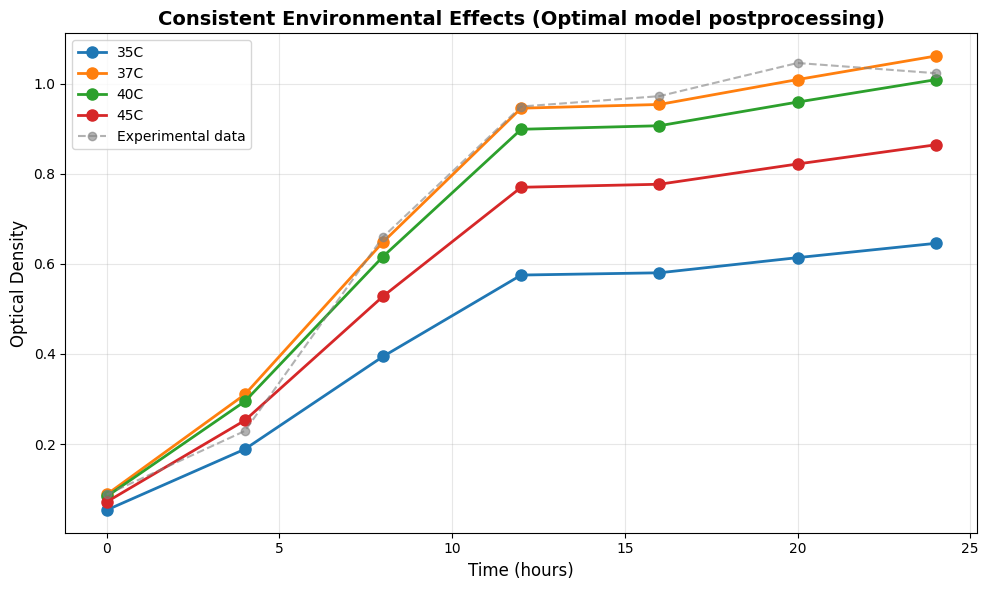

In [13]:
def plot_temperature_comparison(
    time_values: np.ndarray,
    optical_densities: dict[str, np.ndarray],
    experimental_data: pd.DataFrame,
    title: str = 'Consistent Environmental Effects (Optimal model postprocessing)'
):
    plt.figure(figsize=(10, 6))
    
    # Plot model predictions for each temperature
    for label, od_values in optical_densities.items():
        plt.plot(time_values, od_values, 'o-', label=label, linewidth=2, markersize=8)
    
    # Plot experimental data
    plt.plot(
        time_values,
        experimental_data['OpticalDensity'].values,
        'o--',
        label='Experimental data',
        color='gray',
        alpha=0.6
    )
    
    # Configure plot appearance
    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('Optical Density', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_temperature_comparison(
    time_values=_TIME_VALUES,
    optical_densities={
        '35C': optical_density_model_temp35,
        '37C': optical_density_model_temp37,
        '40C': optical_density_model_temp40,
        '45C': optical_density_model_temp45,
    },
    experimental_data=lb3_time_opticaldensity_ph_glucose_protein_37
)